# Basic usage of the Python luxpy package for color science 
* Author: K. A.G. Smet
* Version: 1.2.06
* Date: April 12, 2018
* License: GPLv3

## Basic imports

In [1]:
import luxpy as lx # package for color science calculations 
import matplotlib.pyplot as plt # package for plotting
import numpy as np # fundamental package for scientific computing 
import timeit # package for timing functions

%matplotlib inline 

#### This notebook will only illustrate the basic usage of some of the luxpy modules and functions.
**A full overview of all luxpy package modules and functions can be found in [luxpy_module_overview.md](https://github.com/ksmet1977/luxpy/blob/master/luxpy_module_overview.md).
Each module and function also has a detailed  \__docstring__ for help.**

In [2]:
?lx.spd_to_xyz # get help on function input and output arguments
?lx.cri # get help on cri sub-package

## Working with spectral data

### cri_ref()

As a first example, let’s get (M = 4) spectra normalized at wavelength ('lambda') 560 nm with respective CCTs of 3000 K, 4000 K, 4500 K and 6000 K and respective types: 'BB' (blackbody radiator), 'DL' (daylight phase), 'cierf' (mixed reference illuminant as defined in (CIE224:2017, 2017)) and 'BB':

In [3]:
cieobs = '1964_10' # set CIE observer, i.e. cmf set
ccts = [3000,4000,4500, 6000] # define M = 4 CCTs
ref_types = ['BB','DL','cierf','DL'] # define reference illuminant types

# calculate reference illuminants:
REF = lx.cri_ref(ccts, ref_type = ref_types, norm_type = 'lambda', norm_f = 600)

print('* REF.shape --> (M + 1 x number of wavelengths): {}'.format(REF.shape)) 

* REF.shape --> (M + 1 x number of wavelengths): (5, 471)


### cie_interp()

Secondly, let’s interpolate the REF spectral data to a 400 nm – 700 nm range with a 5 nm spacing, and let the cie_interp() function determine the right kind of interpolation by defining the spectral data type as kind = 'S':

In [5]:
REFi = lx.cie_interp(REF, wl_new = np.arange(400,700+1,5), kind = 'S') 
print('* REFi.shape --> (M + 1 x number of wavelengths): {}'.format(REFi.shape))

* REFi.shape --> (M + 1 x number of wavelengths): (5, 61)



### spd_to_xyz()

Next, the tristimulus values (using the CIE 1964 10° CMFs) of those light source spectra can be obtained as follows:

In [6]:
xyz_REF = lx.spd_to_xyz(REF, cieobs = cieobs) # illuminant xyz

The tristimulus values of set of N reflective samples illuminated by those M sources can be obtained in the following way:

In [7]:
TCS8 = lx._CRI_RFL['cie-13.3-1995']['8'] # 8 TCS from CIE 13.3-1995
xyz_TCS8_REF = lx.spd_to_xyz(REF, cieobs = cieobs, rfl = TCS8, relative = True) 

whereby relative = True (default) specifies that the output tristimulus values are normalized such that a perfect white diffuse sample has Y = 100.



The tristimulus values of the N samples illuminated by the M light sources and of the M light sources themselves can be obtained using (whereby the code is split over two lines using a line separator character ‘\’):

In [8]:
xyz_TCS8_REF_2, xyz_REF_2 = lx.spd_to_xyz(REF, cieobs = cieobs, rfl = TCS8, relative = True, out = 2)

print('* xyz_TCS8_REF_2.shape --> (N x M x 3): {}'.format(xyz_TCS8_REF_2.shape))
print('* xyz_REF_2.shape --> (M x 3): {}'.format(xyz_REF_2.shape))

* xyz_TCS8_REF_2.shape --> (N x M x 3): (8, 4, 3)
* xyz_REF_2.shape --> (M x 3): (4, 3)


### Plotting

A simple plot of the spectral data in REF can be made by the following lines of code:

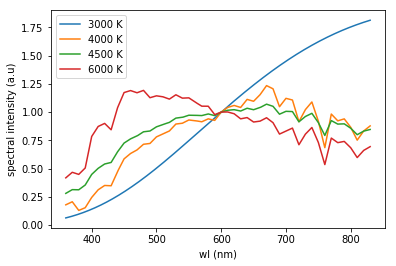

In [9]:
plt.plot(REF[0],REF[1:].T)
plt.xlabel('wl (nm)')
plt.ylabel('spectral intensity (a.u)')
plt.legend(['{} K'.format(x) for x in ccts])
plt.show()

### Individual Observer Color Matching Functions

Color matching functions are stored in a dictionary that can be accessed as follows:

In [10]:
# Get CIE 1931 2° CMFs:
cmf_1931 = lx._CMF['1931_2']['bar']

# List all available CMF sets:
print(lx._CMF['types'])

['1931_2', '1964_10', '2006_2', '2006_10', '1931_2_judd1951', '1931_2_juddvos1978', '1951_20_scotopic', 'cie_std_dev_obs_f1']


A module called 'indvcmf' supports Monte-Carlo generation of individual observer cone fundamentals and XYZ color matching functions (Asano, 2016).


For example, a set cone fundamentals (lms) for a stimulus with field size of 6° for 20 observers aged 32 can be generated as follows:

(4, 20, 3)


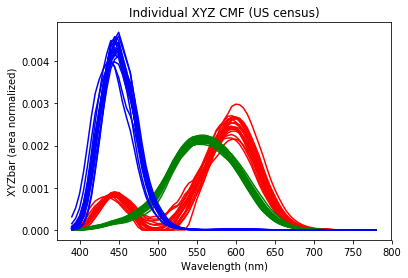

In [11]:
# Get set of 20 individual observer lms-CMFs 
lmsb = lx.indvcmf.genMonteCarloObs(n_obs = 20, list_Age = [32], fieldsize = 6)

# Use US 2010 population census to generate Age Distribution and output as XYZ CMF:
xyzb_us = lx.indvcmf.genMonteCarloObs(n_obs = 20, list_Age = 'us_census', fieldsize = 6, out ='XYZ')

# Plot CMFs:
plt.figure()
plt.plot(xyzb_us[0],xyzb_us[1], color ='r', linestyle='-')
plt.plot(xyzb_us[0],xyzb_us[2], color ='g', linestyle='-')
plt.plot(xyzb_us[0],xyzb_us[3], color ='b', linestyle='-')
plt.xlabel('Wavelength (nm)')
plt.ylabel('XYZbar (area normalized)')
plt.title('Individual XYZ CMF (US census)')

# CalculateXYZ values for REF:
xyz_ind = np.empty((REF.shape[0]-1, xyzb_us.shape[-1],3))
for i in range(xyzb_us.shape[-1]):
    xyz_ind[:,i,:] = lx.spd_to_xyz(REF, cieobs = xyzb_us[...,i],relative = True)
print(xyz_ind.shape)

Categorical observer CMFs can be generated in a similar manner using the indvcmf.genCatObs function.

## Working with colorimetric data

The tristimulus values XYZ obtained earlier can be further transformed to a range of color coordinates. 

### xyz_to_Yuv()

As an example, the transformation to the CIE 1976 u’v’ chromaticity coordinates is outlined below:

In [12]:
Yuv_REF_2 = lx.xyz_to_Yuv(xyz_REF_2)
Yuv_TCS8_REF_2 = lx.xyz_to_Yuv(xyz_TCS8_REF_2)
print("* Yuv_REF_2.shape --> (M x 3): {}".format(Yuv_REF_2.shape))
print("* Yuv_TCS8_REF_2.shape --> (N x M x 3): {}".format(Yuv_TCS8_REF_2.shape))

* Yuv_REF_2.shape --> (M x 3): (4, 3)
* Yuv_TCS8_REF_2.shape --> (N x M x 3): (8, 4, 3)


### asplit(), plotSL() and plot_color_data()

The colorimetric data can be easily plotted. 
1. First the spectrum locus is drawn using plotSL(). This function has several input options (cspace and cieobs respectively determine the color space and CMF set to be used, show = False waits with showing the output graph until everything has been drawn in the axh axes, while BBL = True and DL = True regulate the plotting of a blackbody and daylight locus). 
2. In a next step, the data is prepared for easy plotting by splitting the data array along the colorimetric dimension (last axis) and squeezing out any axes with a 1-dimensional size.
3. Finally, the u’,v’ chromaticity coordinates can be plotted.

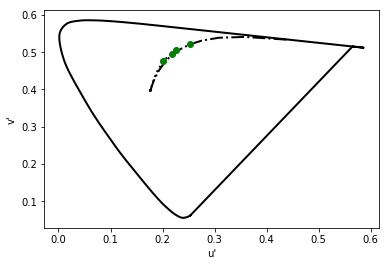

In [13]:
# Step 1:
axh = lx.plotSL(cspace = 'Yuv', cieobs = cieobs, show = False,\
                 BBL = True, DL = True)

# Step 2:
Y, u, v = np.squeeze(lx.asplit(Yuv_REF_2)) # splits array along last axis

# Step 3:
lx.plot_color_data(u, v, formatstr = 'go')

### colortf() and _CIE_ILLUMINANTS

A short-hand color transformation function also exists. This function makes it easy to combine several transformations in one function call. 
In the following example, tristimulus values XYZ are transformed to CIE 1976 u’v’ chromaticity coordinates (tf = 'Yuv' defines the type of transform):


In [14]:
Yuv_REF = lx.colortf(xyz_REF_2, tf = 'Yuv') 

Note that the input does not have to be an array with tristimulus values. One can also perform transformation between for example an array with spectral data and CIE 1976 u’v’ chromaticity coordinates. Any combination of transformations for which the necessary forward (xyz_to_...) and backward (…to_xyz) functions are defined can be made. For example, the spectral data in REF can be readily converted to colorimetric data by specifying the correct transform type (tf = 'spd>Yuv'):

In [15]:
Yuv_REF = lx.colortf(REF, tf = 'spd>Yuv') 

Some color transformations require additional input parameters. This can be supplied as Python dictionary with the parameters names as keys. The forward and backward transform parameters should be supplied to the colortf function using keyword arguments, fwtf and bwtf, respectively. 

For example, let’s transform the Yuv_REF to CIE 1976 CIELAB L*a*b* coordinates, with as white point tristimulus values those of CIE illuminant A. First, the dictionary with input parameters for the forward (i.e. xyz_to_lab) transform is defined:

In [16]:
fwtf_userdefined = {'xyzw' : lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A'])}

whereby the spectrum of the CIE illuminant A is obtained from a LuxPy database with CIE illuminants, i.e. _CIE_ILLUMINANTS.

Next, the transform can be made as follows:

In [17]:
lab_REF2 = lx.colortf(Yuv_REF_2, tf = 'lab', fwtf = fwtf_userdefined)

Input parameters for the forward (only) transform can also be directly entered as keyword arguments to the colortf function:

In [18]:
lab_REF2 = lx.colortf(Yuv_REF_2, tf = 'lab',\
                      xyzw = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['A']))


### xyz_to_cct() and cct_to_xyz()

The correlated color temperature (CCT) and distance to the blackbody locus (Duv) can be obtained, using the Ohno’s method (Ohno, 2014) or using a brute-force search method in the CIE 1960 UCS color space, as follows:

In [19]:
# Use Ohno's approach with a Look-Up-Table:
cct_ohno, duv_ohno = lx.xyz_to_cct(xyz_REF_2, cieobs = cieobs,\
                                   out = 'cct,duv', mode = 'lut') 

# Use a brute-force search approach:
cct_search, duv_search = lx.xyz_to_cct(xyz_REF_2, cieobs = cieobs,\
                                 out = 'cct,duv', mode = 'search') 

whereby cieobs is a specifier for the type of CMFs that were used to calculate the tristimulus input values, out specifies the format of the output and mode determined the method used to obtain the CCT and Duv.

To perform the inverse calculation, i.e. going from CCT and Duv to tristimulus values:

In [15]:
# Use Ohno's approach with a Look-Up-Table:
xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno, duv = duv_ohno,\
                                cieobs = cieobs, mode = 'lut') 

# Use a brute-force search approach:
xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search,\
                           cieobs = cieobs, mode = 'search') 

Note that the brute-force method takes considerably longer than Ohno’s method:

In [20]:
print('\nTime for cct_to_xyz_ohno() to run:')
%timeit xyz_REF_2_ohno = lx.cct_to_xyz(cct_ohno, duv = duv_ohno,\
                                       cieobs = cieobs, mode = 'lut') 
print('\nTime for cct_to_xyz_search() to run:')
%timeit xyz_REF_2_search = lx.cct_to_xyz(cct_search, duv = duv_search,\
                                         cieobs = cieobs, mode = 'search') 


Time for cct_to_xyz_ohno() to run:
89.4 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Time for cct_to_xyz_search() to run:
9.9 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Chromatic adaptation: calculating corresponding colors (.cat)

LuxPy supports basic von Kries type chromatic adaptation transforms, with a wide choice of sensor spaces (e.g. CAT02, CMC2000, …; for an overview see lx.cat._MCATS) and several degree of adaptation formulas.

As an example, let’s calculate the corresponding colors under CIE illuminant D65 (xyzw2) of the 8 CIE TCS illuminated by the spectra in REF (xyzw1) using a two-step (catmode = '1>0>2') chromatic adaptation transform (Kevin A. G. Smet, Zhai, Luo, & Hanselaer, 2017) with CAT02 sensors and with an assumed adapting field luminance, La of resp. 100 cd/m² and 500 cd/m²: 

In [21]:
# Original illumination condition:
xyzw1 = xyz_REF 

# New illumination condition:
xyzw2 = lx.spd_to_xyz(lx._CIE_ILLUMINANTS['D65'],cieobs = cieobs, relative = True) 

# Apply von Kries CAT:
xyz_TCS8_REF_c = lx.cat.apply(xyz_TCS8_REF, xyzw1 = xyzw1, xyzw2 = xyzw2,\
                               catmode = '1>0>2', cattype='vonkries',\
                          D = None, La = np.array([[100,500]]))

The original and corresponding colors can be plotted as follows:

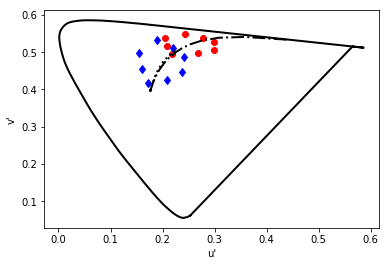

In [22]:
Yuv_TCS8_REF = lx.xyz_to_Yuv(xyz_TCS8_REF) # convert to CIE 1976 u'v'
Yuv_TCS8_REF_c = lx.xyz_to_Yuv(xyz_TCS8_REF_c) # convert to CIE 1976 u'v'

ax = plt.figure().add_subplot(111) # create figure with 1 axes

ax.plot(Yuv_TCS8_REF[:,0,1],Yuv_TCS8_REF[:,0,2],\
        color ='r',marker = 'o', linestyle = 'none')

ax.plot(Yuv_TCS8_REF_c[:,0,1],Yuv_TCS8_REF_c[:,0,2],\
        color ='b',marker ='d', linestyle = 'none')

ax.set_xlabel("u'") # set x-axis label
ax.set_ylabel("v'") # set y-axis label

lx.plotSL(cieobs = cieobs, cspace = 'Yuv', DL = True, BBL = True)

## Color appearance models (.cam)

Several color appearance models (CAM), such as CIECAM02 (Moroney et al., 2002), CAM02-UCS/LCD/SCD (Luo, Cui, & Li, 2006), CAM16 & CAM16-UCS/LCD/SCD(Li et al., 2017), CAM15u (Withouck, Smet, Ryckaert, & Hanselaer, 2015), CAMSWW2016(Kevin A G Smet, Webster, & Whitehead, 2016), have been implemented. In this section, the use of the xyz_to_jab… type wrapper functions will be demonstrated. 

For example, let’s look at the conversion from XYZ tristimulus value to CIECAM02 J,aM,bM coordinates (Similar functionality is supported for the other CAMs):

Text(0.5,0,"b'")

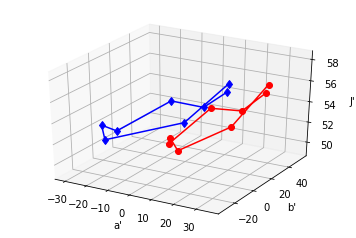

In [23]:
# Use default conditions (see lx.cam._CAM_DEFAULT_CONDITIONS)
JabM_TCS8_REF = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF) # Use default conditions

# Create a dictionary with user defined viewing conditions:
user_conditions = {'D': None, 'Dtype': None,\
                   'La': 500.0, 'Yb': 40.0, 'surround': 'dim'} 
JabM_TCS8_REF_user = lx.xyz_to_jabM_ciecam02(xyz_TCS8_REF, xyzw = xyz_REF,\
                                             conditions = user_conditions)

# Plot color coordinates contained in both arrays in a 3-dimensional graph:
ax = plt.figure().add_subplot(111,projection = '3d')

ax.plot(JabM_TCS8_REF[:,0,1], JabM_TCS8_REF[:,0,2],\
        JabM_TCS8_REF[:,0,0], color = 'r', marker = 'o')
ax.plot(JabM_TCS8_REF_user[:,0,1], JabM_TCS8_REF_user[:,0,2],\
        JabM_TCS8_REF_user[:,0,0], color ='b', marker ='d')

ax.set_zlabel("J'")
ax.set_xlabel("a'")
ax.set_ylabel("b'")

## Color difference calculation (.deltaE)

The deltaE sub-package supports calculation of color differences in various color spaces or color appearance spaces.

The widely used DE2000 color difference formula has been implemented and supports direct input of tristimulus values or CIE 1976 L*a*b* color coordinates. For example, let's calculate the color difference between the color samples illuminated by the first and last light source spectrum in REF.

In [24]:
# Calculate DE2000:
DE00 = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:])

# Calculate DE2000 and output rms average:
DE00i, DE00a = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       avg = lx.math.rms, out ='DEi,DEa', KLCH = [1,1,1])

# Calculate DE2000 and output rms average, but ignore L* and double the kC scaling factor:
DE00i_ab, DE00a_ab = lx.deltaE.DE2000(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       avg = lx.math.rms, out ='DEi,DEa', KLCH = [1,2,1], DEtype = 'ab')

The function DE_camucs supports calculation of color differences in color appearance spaces (CIECAM02, CAM16, CAM02ucs, CAM16lcd, ...):

In [25]:
# Calculate DE in CIECAM02 using default CAM viewing conditions:
DEi_ciecam02 = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='none')

# Calculate DE in CAM02-ucs using default CAM viewing conditions:
DEi_cam02ucs = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='ucs')

# Calculate DE in CAM16-lcd using default CAM viewing conditions:
DEi_cam16lcd = lx.deltaE.DE_camucs(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='cam16', ucstype ='lcd')

A handy function, DE_cspace(), exists that can calculate DE2000, CAMUCS-type color differences, but also color differences in any color space or chromaticity diagram for which the function xyz_to_... is defined. The input arguments are as before, with the additional argument 'tf' specifying the color difference type (i.e. 'DE2000' or 'camucs') or color space (e.g. 'Yuv' or 'lab'). When 'tf' is different from 'DE2000' or 'camucs', there is the possibility of using the KLCH argument to specify different weights for the lightness, chroma and hue dimensions.

In [26]:
# DE2000:
DEi_2000 = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'DE2000')

# DE CAM02-ucs:
DEi_cam02ucs = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', camtype ='ciecam02', ucstype ='ucs', tf = 'camucs')

# DE CIE 1976 L*a*b*:
DEi_lab = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'lab')

# DE CIE 1976 L*a*b* with kL, kC and kH weights different from unity (KLCH = [2,3,4]):
DEi_lab_KLCH = lx.deltaE.DE_cspace(xyz_TCS8_REF[:,0,:], xyz_TCS8_REF[:,-1,:], xyzwt = xyz_REF[:1,:], xyzwr = xyz_REF[-1:,:],\
                       out ='DEi', tf = 'lab', KLCH = [2,3,4])

## Color rendition measures (.cri)

The cri sub-package supports several color rendition metrics, such as CIE13.3-1995 Ra (CIE13.3-1995, 1995), CIE224-2017 Rf (CIE224:2017, 2017), IESTM30 Rf and Rg (David et al., 2015; IES, 2015), CRI2012 (K. Smet, Schanda, Whitehead, & Luo, 2013), MCRI (K A G Smet, Ryckaert, Pointer, Deconinck, & Hanselaer, 2012) and CQS (Davis & Ohno, 2010). It also contains handy functions to construct ‘new’ color fidelity type metrics very easily by changing for example the sample set, averaging method, color space, CIE observer, …

Finally, a sub-package cri.VFPX also supports the calculation of vector field based and pixel based color shifts, of a metameric uncertainty index, …
Wrapper functions have been created specifically dedicated to the standard definition of the published color rendition measures. They can be calculated as follows:


In [27]:
# First get some spectra from the IESTM30 light source database:
spds = lx._IESTM30['S']['data'][:4+1] # N = 4

ciera = lx.cri.spd_to_ciera(spds) # CIE13.3-1995 Ra
cierf = lx.cri.spd_to_cierf(spds) # CIE224-2017 Rf
iesrf_15 = lx.cri.spd_to_iesrf(spds, cri_type = 'iesrf-tm30-15') # IES-TM30-15 Rf
iesrg_15 = lx.cri.spd_to_iesrg(spds, cri_type = 'iesrf-tm30-15') # IES-TM30-15 Rg
iesrf_18 = lx.cri.spd_to_iesrf(spds) # IES-TM30-18 Rf
iesrg_18 = lx.cri.spd_to_iesrg(spds) # IES-TM30-18 Rg
print('CIE 13.3-1995 Ra:')
print(ciera)
print('CIE224-2017 Rf:')
print(cierf)
print('IES TM130-18 Rf:')
print(iesrf_18)
print('IES TM130-18 Rg:')
print(iesrg_18)

CIE 13.3-1995 Ra:
[[7.5878e+01 6.4266e+01 5.6823e+01 5.1516e+01]]
CIE224-2017 Rf:
[[8.0696e+01 7.0229e+01 6.3220e+01 5.6862e+01]]
IES TM130-18 Rf:
[[8.0696e+01 7.0229e+01 6.3220e+01 5.6862e+01]]
IES TM130-18 Rg:
[[8.9829e+01 8.6440e+01 8.4413e+01 8.3539e+01]]


The use of the more versatile spd_to_cri function allows the calculation a color fidelity value using all the same standard parameters as those of the metric defined in cri_type, but with for example a change of the sample set from the IES99 to the IES4880, using a blackbody radiator as reference illuminant and using the rms instead of the mean to average the color differences before calculating the general color fidelity index. Requested output can be specified by a string using out: 

In [28]:
Rf_custom, Rg_custom, cct, duv = lx.cri.spd_to_cri(spds, cri_type = 'ies-tm30',\
                             out = 'Rf,Rg,cct,duv', avg = lx.math.rms,\
                             sampleset = lx._CRI_RFL['ies-tm30']['4880']['5nm'],\
                             ref_type = 'BB')
print('Rf_custom:')
print(Rf_custom)
print('Rg_custom:')
print(Rg_custom)
print('cct:')
print(cct)

Rf_custom:
[[7.7483e+01 6.7108e+01 5.9424e+01 5.2895e+01]]
Rg_custom:
[[8.8549e+01 8.6448e+01 8.4454e+01 8.3509e+01]]
cct:
[[6.4248e+03]
 [4.2247e+03]
 [3.4470e+03]
 [2.9393e+03]]


The LuxPy.cri sub-package also supports a function that calculates several color rendition index values and provides TM30-like graphical output:

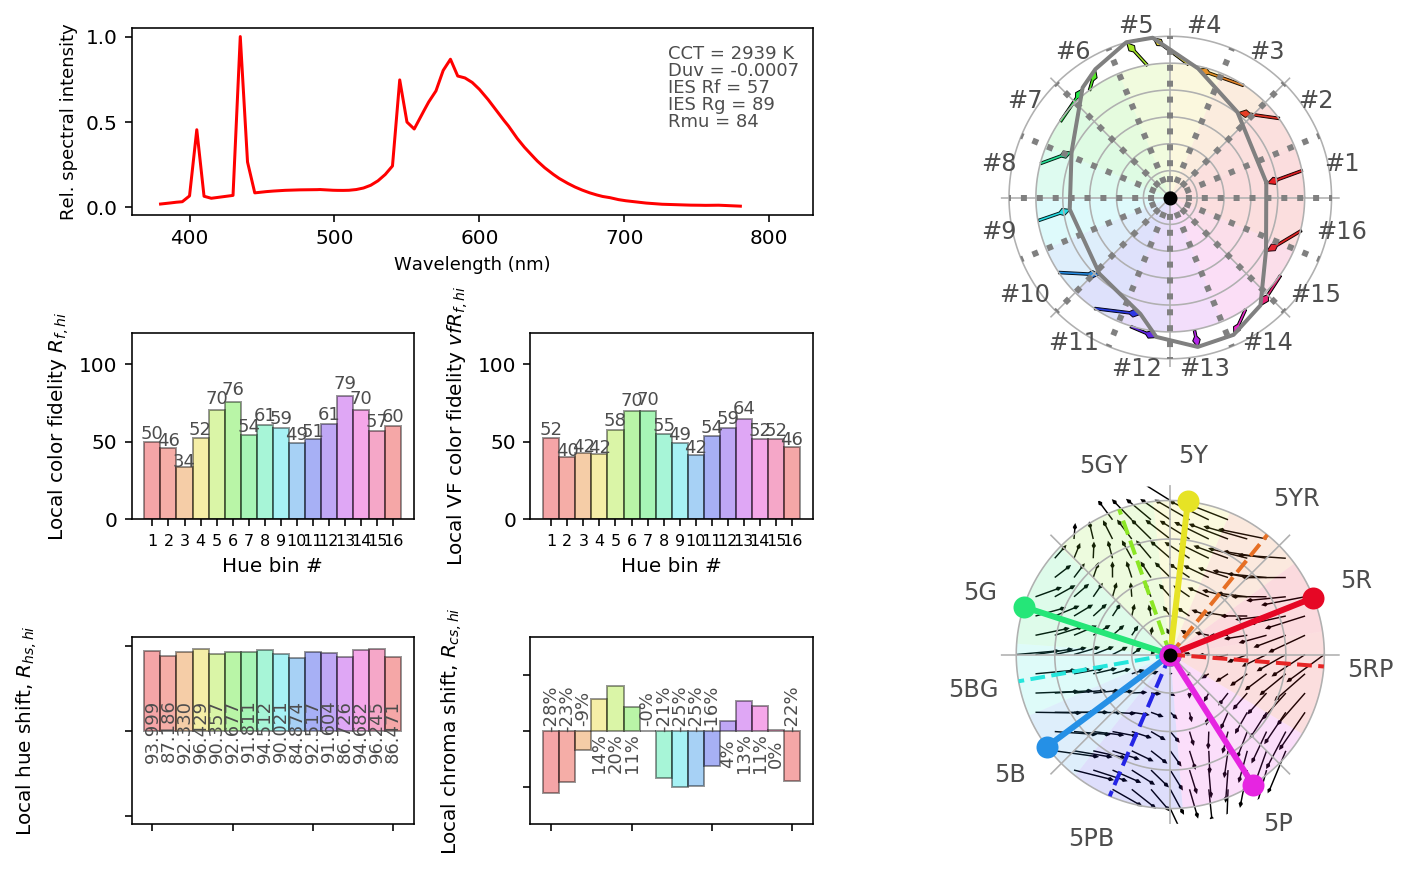

In [29]:
# Calculate and plot IES TM30 color rendition measures:
SPD = lx._CIE_ILLUMINANTS['F4']
data, _, _ = lx.cri.plot_cri_graphics(SPD)

The output format of and displayed information in some of the right hand graphs can be easily customized. For example the following code turns off the coloring of the right-hand side color icons, plots the vector field base color shifts in grey and plots the distortion of the color gamut using circle fields (the color of the distorted circles provides information on the size of the hue shift, red being larger):

Keys in dictionary with color rendition data:
dict_keys(['SPD', 'cct', 'duv', 'bjabt', 'bjabr', 'Rf', 'Rg', 'Rfi', 'Rfhi', 'Rchhi', 'Rhshi', 'Rt', 'Rti', 'Rfhi_vf', 'Rfcshi_vf', 'Rfhshi_vf', 'dataVF', 'cri_type'])


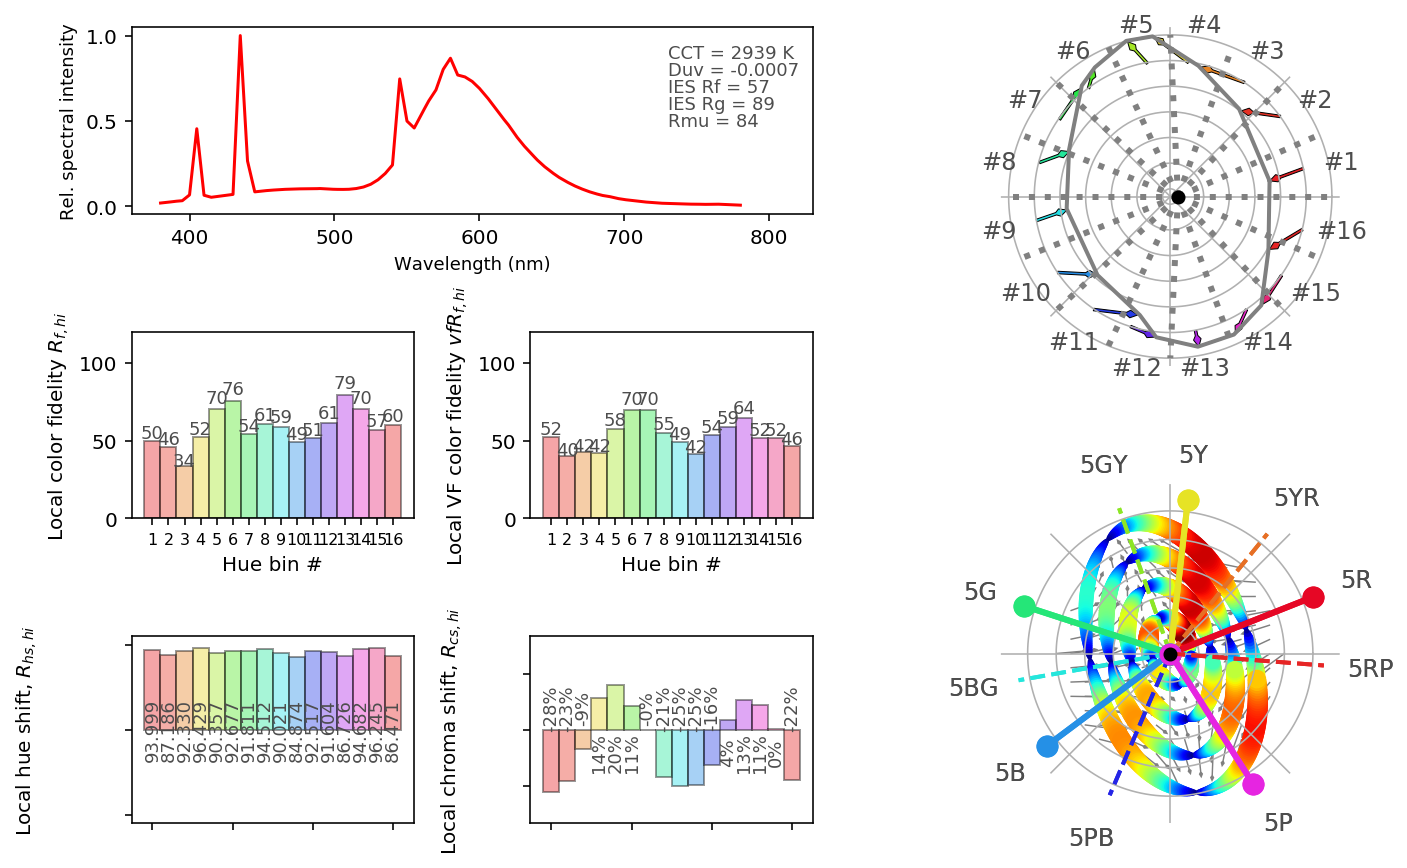

In [30]:
data, _, _ = lx.cri.plot_cri_graphics(SPD, plot_bin_colors = False, \
                                vf_plot_bin_colors = False,\
                                vf_color = 'grey', plot_CF = True)
print("Keys in dictionary with color rendition data:")
print(data.keys())

## Spectral and colorimetric data using LuxPy classes

Spectral and colorimetric data also have their own dedicated classes which have basic functionality by providing class method wrappers to some of the LuxPy functions. 

An instance of the class SPD can be created by initiating it directly with a NumPy.ndarray or by providing the path to a datafile as input. Using the ‘spds’ data array specified above (containing blackbody radiator and daylight phase spectra of 4500 K):

In [31]:
spds = lx.cri_ref([4500,4500], ref_type = ['BB','DL'], wl3 = [380,780,5]) 
spds_inst = lx.SPD(spds)

The advantage of the creating such an SPD instance is that it is easy to store some additional specific info related to the data:

In [32]:
print("Spectral data type is stored in .dtype field: {}".format(spds_inst.dtype))
print("Wavelength are in .wl field: {}".format(spds_inst.wl.shape))
print("Value are in .value field: {}".format(spds_inst.value.shape))
print("Number of spds is contained in .N field: {}".format(spds_inst.N))
print("Shape of REFo.value is in .shape field: {}".format(spds_inst.shape)) 

Spectral data type is stored in .dtype field: S
Wavelength are in .wl field: (81,)
Value are in .value field: (2, 81)
Number of spds is contained in .N field: 2
Shape of REFo.value is in .shape field: (2, 81)


And it especially allows for very readable code, when performing several operations in sequence:

In [33]:
xyz_inst = lx.SPD(spds).cie_interp(wl_new = [400, 700, 5]).normalize(norm_type = 'area').to_xyz()

The code above produced an instance of class XYZ, xyz_inst, which itself has several methods for easy use. The further conversion to CIELUV L*u*v* coordinates, with assumed white point the equi-energy white, can for example be done as follows:

In [34]:
luv_inst = xyz_inst.ctf(dtype = 'luv', xyzw = np.array([[100, 100, 100]]))

In each instance, the field ‘value’ contains the actual data. For the SPD class, this is the spectral data stripped of its wavelengths (contained in a ‘wl’ field), for the XYZ and LAB classes, this is an array with the tristimulus values and specified colorimetric data, respectively. For the latter a field called ‘dtype’ keeps track of what type of data (e.g. ‘xyz’, ‘Yuv’, ‘luv’, …) the instance contains. In addition to a field ‘cieobs’, which specifies the CMF set used, instances of the class LAB also contain a field ‘cspace_par’ that contains a Python dictionary with a set of parameters (e.g. ‘xyzw’) relevant to the calculation of the colorimetric values. 

In [35]:
print(luv_inst.cspace_par)

{'cieobs': '1931_2', 'xyzw': array([[100, 100, 100]]), 'M': None, 'scaling': None, 'Lw': None, 'Yw': None, 'Yb': None, 'conditions': None, 'yellowbluepurplecorrect': None, 'mcat': None, 'ucstype': None, 'fov': None, 'parameters': None}


Each class also contains a basic plotting method for a quick look at the data contained in the instance:

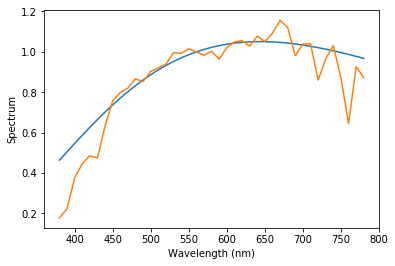

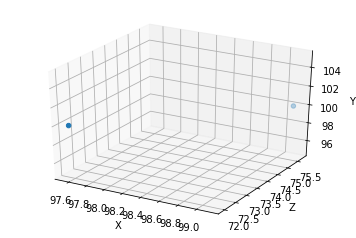

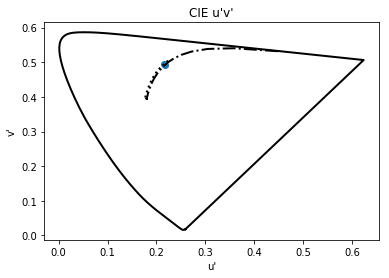

In [36]:
spds_inst.plot() #class SPD
xyz_inst.plot() #class XYZ
xyz_inst.ctf(dtype = 'Yuv').plot(plt_type = '2d', title = "CIE u'v'") #class LAB
lx.plotSL() # plots spectrum locus

## CIE Photobiological quantities (CIE TN003-2015) (.ciephotbio)

The sub-package .ciephotbio supports the calculation of the CIE photobiological quantities ($\alpha$-opic irradiance and equivalent illuminance) defined in TN003:2015 (CIE-TN003:2015, 2015).
The input spectral irradiance can be in W/m²/nm (default) or in $\mu$W/m/cm². The output is in SI units.

In [37]:
# Define a 4200 K blackbody radiator:
sid = lx.blackbody(4200, lx.getwlr([378,782,1]))

# Calculate the a-opic irradiance Eea and equivalent illuminance Ee for the blackbody radiator normalized to 100 lx:
Ees,Es = lx.ciephotbio.spd_to_aopicE(sid, E = 100)

# Print results:
print("Photoreceptor cells:")
print(lx.ciephotbio._PHOTORECEPTORS)
print("\na-opic irradiance symbols:")
print(lx.ciephotbio._Ee_SYMBOLS)
print("a-opic irradiance units:")
print(lx.ciephotbio._Ee_UNITS)
print("a-opic irradiance values:")
print(Ees)
print("\na-opic illuminance symbols:")
print(lx.ciephotbio._E_SYMBOLS)
print("a-opic illuminance units:")
print(lx.ciephotbio._E_UNITS)
print("a-opic illuminance values:")
print(Es)

Photoreceptor cells:
['l-cone', 'm-cone', 's-cone', 'rod', 'iprgc']

a-opic irradiance symbols:
['Ee,lc', 'Ee,mc', 'Ee,sc', 'Ee,r', 'Ee,z']
a-opic irradiance units:
['W⋅m−2', 'W⋅m−2', 'W⋅m−2', 'W⋅m−2', 'W⋅m−2']
a-opic irradiance values:
[[1.7141e-01 1.5162e-01 4.9698e-02 1.2215e-01 9.7921e-02]]

a-opic illuminance symbols:
['E,lc', 'E,mc', 'E,sc', 'E,r', 'E,z']
a-opic illuminance units:
['lux', 'lux', 'lux', 'lux', 'lux']
a-opic illuminance values:
[[9.9220e+01 9.4011e+01 6.5862e+01 8.6164e+01 8.1511e+01]]


## Creating and optimizing multi-component spectra (.spdbuild)

The .spdbuild sub_package supports creating Gaussian, monochromatic (Ohno, 2005) and phosphor LED-type (Smet et al. 2011) spectra, and combining them to multi-component spectra. It also supports automatic flux calculations to obtain a desired spectrum chromaticity. Additional objective functions can also be used to optimize the component fluxes to these additional constraints. This section will only briefly introduce some of its features. For more info the reader is referred to the __doc__ strings of the module functions.

As a first example, let’s start with the creation of 4 monochromatic LEDs and import the module into the global namespace for ease of use. 


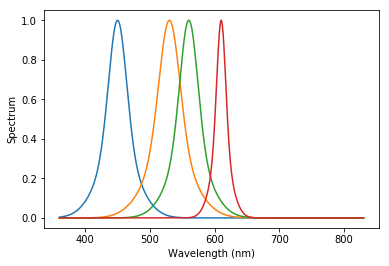

In [40]:
import luxpy.toolboxes.spdbuild as spb 

# Set peak wavelengths:
peakwl = [450,530,560,610]

# Set Full-Width-Half-Maxima:
fwhm = [30,35,30,15] 

S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm)

# Plot component spds:
lx.SPD(S).plot()

Next, let's create 2 phosphor type (one with 1 phosphor and one with 2 phosphors) and one monochromatic LEDs. 

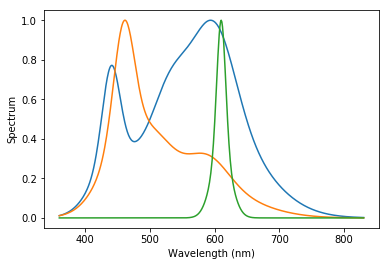

In [41]:
# Set peak wavelengths of monochromatic leds:
peakwl = [440,460,610]

# Set Full-Width-Half-Maxima of monochromatic leds:
fwhm = [30,35,15] 

# Set phosphor strengths:
strength_ph = [1.5, 0.4, 0]

# Set phosphor 1 parameters:
strength_ph1 = [1, 1, 0]
peakwl_ph1 = [530, 510, 1]
fwhm_ph1 = [60, 60, 60]

# Set phosphor 2 parameters:
strength_ph2 = [2, 1, 0]
peakwl_ph2 = [600, 590, 590]
fwhm_ph2 = [70, 70, 70]


S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm,\
                    strength_ph = strength_ph, \
                    strength_ph1 = strength_ph1,\
                    peakwl_ph1 = peakwl_ph1,\
                    fwhm_ph1 = fwhm_ph1,\
                    strength_ph2 = strength_ph2,\
                    peakwl_ph2 = peakwl_ph2,\
                    fwhm_ph2 = fwhm_ph2)

# Plot component spds:
lx.SPD(S).plot()

One can also set them a specific target chromaticity, specified by 'target' ('tar_type' specifies the type of target, e.g. 'cct', 'Yxy', ... and cspace_bwtf is dict specifying the parameters need for the backward transformation called in colortf() inside spd_builder()). The code below calculates the fluxes required for a cct = 3500 K (Duv = 0). There are only 2 spectra plotted in the figure below as any set of 3 spectral components, i.e. monochromatic led and 2 phosphors, for which the target is out of gamut results in an array of NaN's. 

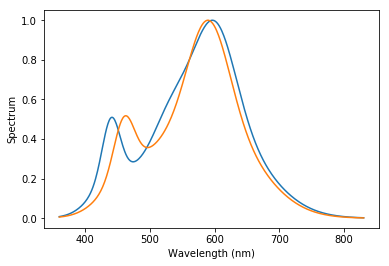

In [42]:
cieobs = '1931_2'
cspace_bwtf = {'cieobs' : cieobs, 'mode' : 'search'}
S = spb.spd_builder(peakwl = peakwl, fwhm = fwhm,\
                    strength_ph = strength_ph, \
                    strength_ph1 = strength_ph1,\
                    peakwl_ph1 = peakwl_ph1,\
                    fwhm_ph1 = fwhm_ph1,\
                    strength_ph2 = strength_ph2,\
                    peakwl_ph2 = peakwl_ph2,\
                    fwhm_ph2 = fwhm_ph2,\
                    target = 3500, tar_type = 'cct',\
                    cspace_bwtf = cspace_bwtf)

# Plot component spds:
lx.SPD(S).plot()

The package also supports spectra optimization beyond the target chromaticity when there are more than 3 spectral components provided.

The following code block provides a practical example of flux optimization with fixed component spectra using objective functions for a target chromaticity of 4000 K (Duv = 0). The objective functions and their target values are specified as two lists. For this example the IES Rf and Rg measures were chosen with target values of resp. 90 and 110. The optimization is done using the '2mixer' optimizer (another option is '3mixer'). See notes in ?lx.spdbuild.spd_optimizer.

Optimization terminated successfully.
         Current function value: 0.077599
         Iterations: 21
         Function evaluations: 44

Results (optim,target):
cct(K): (3500.0,3500.0)
Rf: (85.99,90.00)
Rg: (103.01, 110.00)


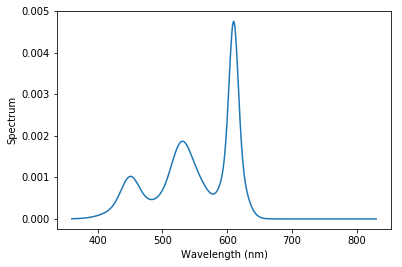

In [43]:
target = 3500
peakwl = [450,530,560,610]
fwhm = [30,35,30,15] 
obj_fcn = [lx.cri.spd_to_iesrf, lx.cri.spd_to_iesrg]
obj_tar_vals = [90,110]
S, _ = spb.spd_optimizer(target = target, \
                          tar_type = 'cct',\
                          cspace_bwtf = cspace_bwtf,\
                          optimizer_type = '2mixer',\
                          peakwl = peakwl, \
                          fwhm = fwhm,\
                          obj_fcn = obj_fcn, \
                          obj_tar_vals = obj_tar_vals,\
                          verbosity = 0)

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
cct = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search')[0,0]
Rf, Rg = [fcn(S)[0,0] for fcn in obj_fcn]
print('\nResults (optim,target):')
print("cct(K): ({:1.1f},{:1.1f})".format(cct, target))
print("Rf: ({:1.2f},{:1.2f})".format(Rf, obj_tar_vals[0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg, obj_tar_vals[1]))


#plot spd:
plt.figure()
lx.SPD(S).plot()

In addition to lux-only optimization, the peak wavelengths and full-width-half-maxima of the components can also be optimized. The example below calculates a spectrum with a CCT of 3500 K (Duv = 0) and optimized for IES Rf and Rg having respective target values of 90 and 110.
The spectrum is build from 6 components with free peak wavelength, fwhm and fluxes.

Optimization terminated successfully.
         Current function value: 0.047608
         Iterations: 1192
         Function evaluations: 1797

Results (optim,target):
cct(K): (3500.0,3500.0)
Rf: (86.93,90.00)
Rg: (106.35, 110.00)


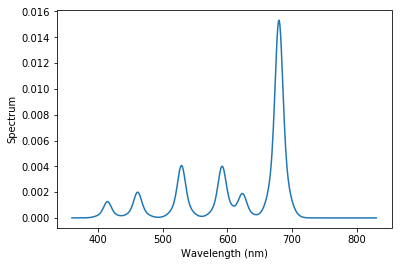

In [44]:
S, _ = spb.spd_optimizer(target = target, \
                      tar_type = 'cct',\
                      cspace_bwtf = cspace_bwtf,\
                      optimizer_type = '2mixer',\
                      N_components = 6,
                      obj_fcn = obj_fcn, \
                      obj_tar_vals = obj_tar_vals,\
                      verbosity = 0)

# Check output agrees with target:
xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
cct = lx.xyz_to_cct(xyz, cieobs = cieobs, mode = 'search')[0,0]
Rf, Rg = [fcn(S)[0,0] for fcn in obj_fcn]
print('\nResults (optim,target):')
print("cct(K): ({:1.1f},{:1.1f})".format(cct, target))
print("Rf: ({:1.2f},{:1.2f})".format(Rf, obj_tar_vals[0]))
print("Rg: ({:1.2f}, {:1.2f})".format(Rg, obj_tar_vals[1]))

#plot spd:
plt.figure()
lx.SPD(S).plot()